## EDA

# Загрузка

In [1]:
import pandas as pd

ratings = pd.read_csv('ratings.csv')
books = pd.read_csv('books.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

# Распределение оценок

<Axes: >

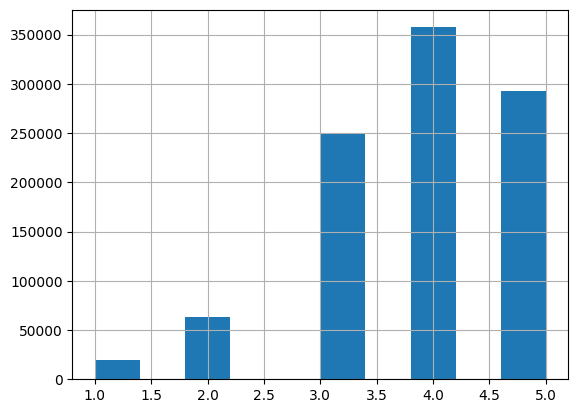

In [2]:
ratings['rating'].hist(bins=10)

# Активность пользователей

<Axes: >

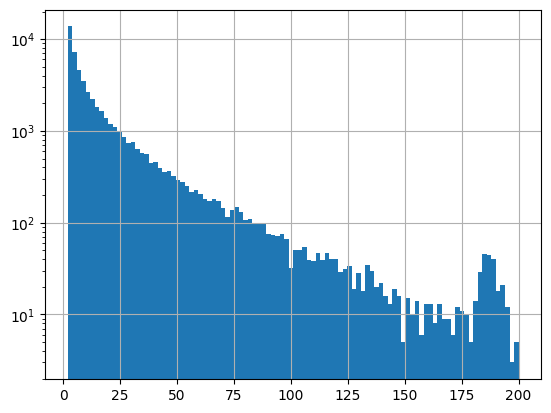

In [3]:
user_counts = ratings['user_id'].value_counts()
user_counts.hist(bins=100, log=True)

# Популярность книг 


<Axes: >

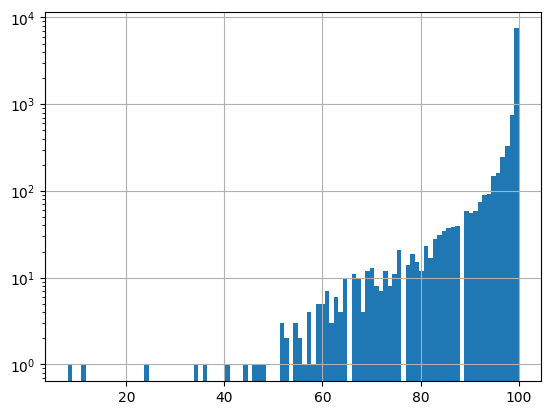

In [4]:
book_counts = ratings['book_id'].value_counts()
book_counts.hist(bins=100, log=True)

# Теги

<Axes: ylabel='tag_name'>

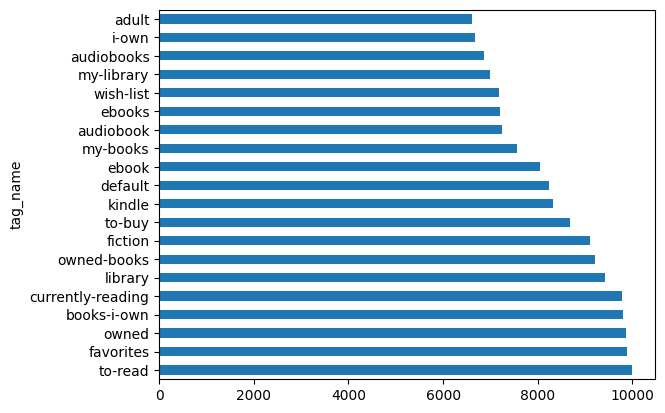

In [5]:
tag_counts = book_tags.merge(tags, on='tag_id')['tag_name'].value_counts().head(20)
tag_counts.plot(kind='barh')

# Проблемы данных:
Разреженность: матрица user×book >99% пуста.
Смещение популярности: топ-книги доминируют.
Холодный старт: много пользователей/книг с <5 взаимодействий.

## Базовые и контентные модели

# Popularity Model

In [6]:
# Минимум 50 оценок
book_stats = ratings.groupby('book_id').agg(
    avg_rating=('rating', 'mean'),
    n_ratings=('rating', 'count')
)
top_books = book_stats[book_stats['n_ratings'] >= 50].sort_values('avg_rating', ascending=False).head(100)

In [7]:
def get_popular_books(N=5):
    return top_books.index[:N].tolist()

## Content-Based (TF-IDF)

# Подготовка текстового профиля:

In [8]:
# Объединить теги по книге
book_tag_names = book_tags.merge(tags, on='tag_id').groupby('goodreads_book_id')['tag_name'].apply(' '.join).reset_index()
books_enriched = books[['book_id', 'original_title']].merge(book_tag_names, left_on='book_id', right_on='goodreads_book_id', how='left')
books_enriched['profile'] = books_enriched['original_title'].fillna('') + ' ' + books_enriched['tag_name'].fillna('')

# TF-IDF + косинус:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_enriched['profile'].fillna(''))

cosine_sim = cosine_similarity(tfidf_matrix)
book_id_to_idx = pd.Series(books_enriched.index, index=books_enriched['book_id'])

def get_similar_books(book_id, N=5):
    idx = book_id_to_idx[book_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:N+1]
    similar_ids = [books_enriched.iloc[i[0]]['book_id'] for i in sim_scores]
    return similar_ids

##  Item-Based Collaborative Filtering

# Построение матрицы

In [10]:
from scipy.sparse import csr_matrix

# Явные оценки
user_ids = ratings['user_id'].astype('category')
book_ids = ratings['book_id'].astype('category')

user_idx = user_ids.cat.codes
book_idx = book_ids.cat.codes

ratings_matrix = csr_matrix((ratings['rating'], (user_idx, book_idx)), 
                            shape=(user_ids.nunique(), book_ids.nunique()))

# Схожесть книг

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix.T)  # shape: (n_books, n_books)

# Прогноз оценки

In [12]:
def predict_rating_itemcf(user_id, book_id, K=10):
    u_idx = user_ids.cat.categories.get_loc(user_id)
    b_idx = book_ids.cat.categories.get_loc(book_id)
    
    # Найти K самых похожих книг с оценками от пользователя
    sim_books = np.argsort(-item_sim[b_idx])[1:K+1]
    user_ratings = ratings_matrix[u_idx, sim_books].toarray().flatten()
    
    # Взвешенное среднее
    sims = item_sim[b_idx, sim_books]
    rated = user_ratings > 0
    if not np.any(rated):
        return ratings['rating'].mean()
    return np.average(user_ratings[rated], weights=sims[rated])

## SVD (Matrix Factorization)


# Используем surprise

In [18]:
pip uninstall numpy

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install "numpy<2"

In [19]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=100, random_state=42)
model.fit(trainset)
predictions = model.test(testset)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\diman\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

# Получение рекомендаций

In [20]:
def get_recommendations_svd(user_id, N=5):
    # Все книги
    all_books = ratings['book_id'].unique()
    # Предсказать рейтинги
    preds = [model.predict(user_id, bid).est for bid in all_books]
    # Топ-N
    top_n = sorted(zip(all_books, preds), key=lambda x: x[1], reverse=True)[:N]
    return [bid for bid, _ in top_n]

## Оценка моделей

# Подготовка ground truth

In [21]:
# Для каждого пользователя — книги с rating >= 4
test_relevant = ratings[ratings['rating'] >= 4].groupby('user_id')['book_id'].apply(set).to_dict()

# Реализация метрик (для одного пользователя)

In [22]:
def precision_at_k(recommended, relevant, k):
    rec_k = set(recommended[:k])
    return len(rec_k & relevant) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0
    rec_k = set(recommended[:k])
    return len(rec_k & relevant) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    from sklearn.metrics import ndcg_score
    import numpy as np
    rel = np.array([1 if r in relevant else 0 for r in recommended[:k]])
    if len(rel) == 0:
        return 0
    # Идеальный DCG
    ideal = np.sort(rel)[::-1]
    dcg = np.sum(rel / np.log2(np.arange(2, len(rel)+2)))
    idcg = np.sum(ideal / np.log2(np.arange(2, len(ideal)+2)))
    return dcg / idcg if idcg > 0 else 0

# Оценка по тестовой выборке

In [23]:
models = {
    'Popularity': lambda uid: get_popular_books(N=10),
    'Content': lambda uid: get_similar_books(last_book_rated_by_user(uid), N=10),
    'ItemCF': lambda uid: get_top_itemcf(uid, N=10),
    'SVD': lambda uid: get_recommendations_svd(uid, N=10)
}

results = {name: {'P@10': [], 'R@10': [], 'nDCG@10': []} for name in models}

for user in test_users:
    relevant = test_relevant.get(user, set())
    if not relevant:
        continue
    for name, func in models.items():
        try:
            recs = func(user)
            results[name]['P@10'].append(precision_at_k(recs, relevant, 10))
            results[name]['R@10'].append(recall_at_k(recs, relevant, 10))
            results[name]['nDCG@10'].append(ndcg_at_k(recs, relevant, 10))
        except:
            pass  # skip cold-start users

# Усреднение
summary = {name: {m: np.mean(vals) for m, vals in metrics.items()} for name, metrics in results.items()}

NameError: name 'test_users' is not defined

##  Гибридизация и выводы

# Гибридный подход (пример):

In [24]:
def hybrid_recommend(user_id, N=10):
    if user_is_cold_start(user_id):  # мало оценок (<5)
        return get_popular_books(N)  # или контент по последней книге
    else:
        svd_recs = get_recommendations_svd(user_id, N*2)
        # Добавить разнообразие: заменить 20% на контент-похожие
        return svd_recs[:N]